In [1]:
pip install deap

     |████████████████████████████████| 163kB 2.2MB/s 


In [2]:
#Importamos las librerías y dependencias
import random
import math
import numpy as np
from deap import base
from deap import creator
from deap import tools
from deap import algorithms
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.layers as LK
import tensorflow.keras.models as MK


In [3]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [4]:
# Definición de los datos de entrenamiento
mnist = keras.datasets.mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()
print("X_train shape", X_train.shape)
print("y_train shape", y_train.shape)
print("X_test shape", X_test.shape)
print("y_test shape", y_test.shape)

11493376/11490434 [==============================] - 0s 0us/step
X_train shape (60000, 28, 28)
y_train shape (60000,)
X_test shape (10000, 28, 28)
y_test shape (10000,)


In [5]:
X_train[0].shape

(28, 28)

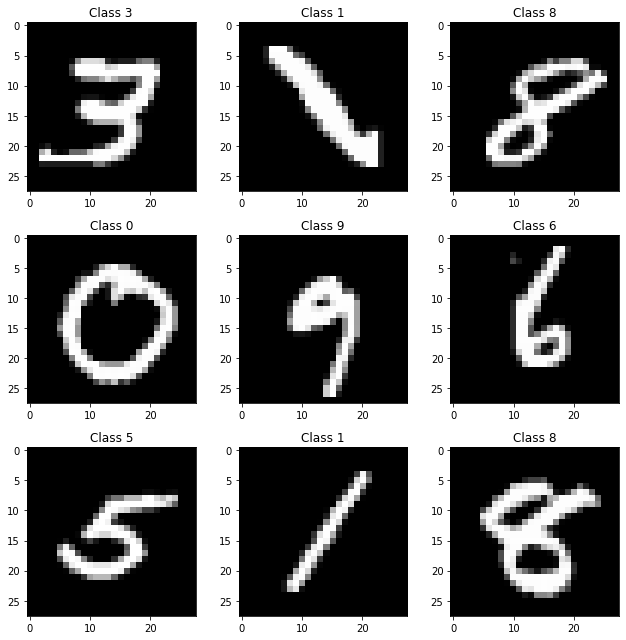

In [6]:
plt.rcParams['figure.figsize'] = (9,9) # Make the figures a bit bigger
for i in range(9):
    plt.subplot(3,3,i+1)
    num = random.randint(0, len(X_train))
    plt.imshow(X_train[num], cmap='gray', interpolation='none')
    plt.title("Class {}".format(y_train[num]))
    
plt.tight_layout()

In [7]:
#X_train = X_train.reshape(60000, 784) # reshape 60,000 28 x 28 matrices into 60,000 784-length vectors.
#X_test = X_test.reshape(10000, 784)   # reshape 10,000 28 x 28 matrices into 10,000 784-length vectors.
X_train = X_train.reshape((X_train.shape[0],28,28,1))
X_test = X_test.reshape((X_test.shape[0],28,28,1))
X_train = X_train.astype('float32')   # change integers to 32-bit floating point numbers
X_test = X_test.astype('float32')
X_train /= 255                        # normalize each value for each pixel for the entire vector for each input
X_test /= 255

print("Training matrix shape", X_train.shape)
print("Testing matrix shape", X_test.shape)

Training matrix shape (60000, 28, 28, 1)
Testing matrix shape (10000, 28, 28, 1)


In [8]:
nb_classes = 10 # number of unique digits
Y_train = keras.utils.to_categorical(y_train, nb_classes)
Y_test = keras.utils.to_categorical(y_test, nb_classes)

In [9]:
# se crean los objetos para maximizar o minimizar
#creator.create("FitnessMax", base.Fitness, weights = (1.0,))
#creator.create("Individuo", list, fitness=creator.FitnessMax)

creator.create("FitnessMin", base.Fitness, weights = (-1.0,))
creator.create("individuo", list, fitness=creator.FitnessMin)

In [47]:
for i in range(4,6):
  print(i)

4
5


In [72]:
#Se define la función objetivo, x tiene 3 posiciones
def funcion_objetivo(x):
    
    #constraints  
    for i in range(2):
         xi = int(np.floor(x[i]/10))
         if xi not in {3,5,7,9}:
             return 5,
    
    for i in range(2,6):
        xi = int(np.floor(x[i]))
        if xi > 100 or xi < 10:
            return 5,
        
    
    for i in range(6,8):
        xi = x[i]/100
        if xi <= 0 or xi >= 1:
            return 5,  
        
      
    K1= int(np.floor(x[0]/10))
    K2= int(np.floor(x[1]/10))
    
    F1= int(np.floor(x[2]))
    F2= int(np.floor(x[3]))
    N1= int(np.floor(x[4]))
    N2= int(np.floor(x[5]))

    D1= x[6]/100
    D2= x[7]/100


    modelo = keras.models.Sequential()
    modelo.add(keras.layers.Conv2D(F1, (K1, K1), padding = 'same', activation = 'relu', input_shape=(28, 28, 1)))
    modelo.add(keras.layers.MaxPool2D((2, 2), (2, 2)))
    modelo.add(keras.layers.Dropout(D1))
    modelo.add(keras.layers.Conv2D(F2, (K2, K2), padding = 'valid', activation = 'relu'))
    modelo.add(keras.layers.MaxPool2D((2, 2), (2, 2)))
    modelo.add(keras.layers.Dropout(D2))
    modelo.add(keras.layers.Flatten())
    modelo.add(keras.layers.Dense(N1, activation = 'relu'))
    modelo.add(keras.layers.Dense(N2, activation = 'relu'))    
    modelo.add(keras.layers.Dense(10, activation='softmax')) 
    
    #modelo.summary()

    modelo.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    modelo.fit(X_train, Y_train,
          batch_size=128, epochs=5,
          verbose=0)
    
    score = modelo.evaluate(X_test, Y_test, verbose=0)
    return score[0],

In [77]:
toolbox = base.Toolbox()
# Search range or Gene generation range
toolbox.register("attr_uniform", random.uniform, 10, 100)
# Generación del inviduo, 
# La cantidad de posiciones del individuo determina la cantidad de variables a trabajar
toolbox.register("individuo", tools.initRepeat, creator.individuo, 
                 toolbox.attr_uniform, 8)
# Generación de la población
toolbox.register("poblacion", tools.initRepeat, list, 
                 toolbox.individuo, 15)

In [78]:
# Registro de operaciones genéticas
# Parece que los nombres no se pueden modificar
toolbox.register("evaluate", funcion_objetivo)
#toolbox.register("mate", tools.cxOnePoint)
#toolbox.register("mate", tools.cxUniform,indpb=0.25)
toolbox.register("mate", tools.cxBlend, alpha=0.5)
toolbox.register("mutate", tools.mutGaussian, mu=0, 
                 sigma= 5, indpb=0.1)
toolbox.register("select", tools.selTournament, tournsize=3)

In [79]:
def plot_evolucion(log):
    """
    Representa la evolución del mejor individuo en cada generación
    """
    gen = log.select("gen")
    fit_mins = log.select("min")
    fit_maxs = log.select("max")
    fit_ave = log.select("avg")
    fig, ax1 = plt.subplots()
    ax1.plot(gen, fit_mins, "b")
    ax1.plot(gen, fit_maxs, "r")
    ax1.plot(gen, fit_ave, "--k")
    ax1.fill_between(gen, fit_mins, fit_maxs, 
                     where=fit_maxs >= fit_mins, facecolor='g', alpha = 0.2)
    ax1.set_xlabel("Generacion")
    ax1.set_ylabel("Fitness")
    ax1.set_ylim([-10, 160])
    ax1.legend(["Min", "Max", "Avg"], loc="lower center")
    plt.grid(True)
    plt.savefig("Convergencia.eps", dpi = 300)

gen	nevals	avg    	std    	min      	max
0  	15    	4.07652	1.85634	0.0647273	5  
1  	12    	4.67098	1.23107	0.0647273	5  
2  	14    	4.67098	1.23107	0.0647273	5  
3  	14    	4.66872	1.23954	0.0307943	5  
4  	10    	5      	0      	5        	5  
5  	12    	4.66869	1.23966	0.030315 	5  
6  	10    	3.67477	2.19764	0.0294339	5  
7  	11    	2.35234	2.47667	0.0290802	5  
8  	13    	1.02566	1.98718	0.0256926	5  
9  	12    	1.35581	2.19753	0.0267646	5  
10 	14    	0.362379	1.23946	0.0244285	5  
11 	12    	0.030783	0.00297016	0.0244285	0.0376211
12 	9     	1.35407 	2.19858   	0.0244285	5        
13 	10    	1.68487 	2.34415   	0.0247205	5        
14 	12    	0.357871	1.24066   	0.0235272	5        


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: The parameter where must have the same size as x in fill_between(). This will become an error in future versions of Matplotlib.
  
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


15 	12    	0.357418	1.24078   	0.0227836	5        
Mejor fitness: 0.022784
Mejor individuo [78.86328769410093, 79.64431276077468, 41.157218261617196, 79.3468400050864, 51.20931996911536, 71.36554311264864, 43.879979119324396, 59.01073604804424]


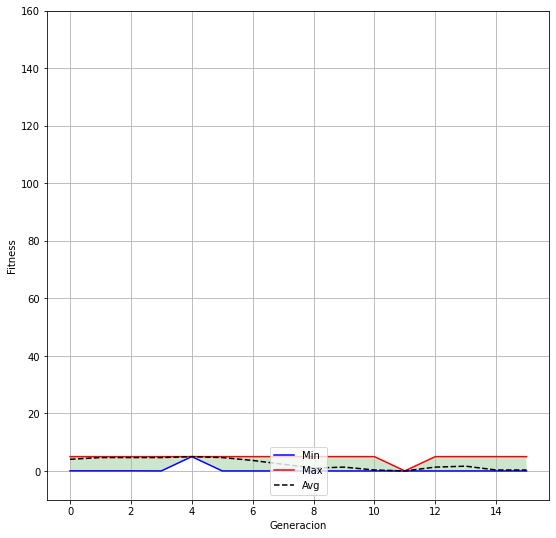

In [81]:
# Función principal
#random.seed(42)
# Configuración de los parámetros del AG
CXPB, MUTPB, NGEN = 0.8, 0.1, 15
pop = toolbox.poblacion() 
hof = tools.HallOfFame(1) 
stats = tools.Statistics(lambda ind: ind.fitness.values) 
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)
logbook = tools.Logbook()
pop, logbook = algorithms.eaSimple(pop, toolbox, cxpb=CXPB, 
                                       mutpb=MUTPB, ngen=NGEN, stats=stats, 
                                       halloffame=hof, verbose=True)
#    return hof, logbook 
#best, log = main()
print("Mejor fitness: %f" %hof[0].fitness.values)
print("Mejor individuo %s" %hof[0])
plot_evolucion(logbook)

In [82]:

x=hof[0]

print('HOF: ',x)  

K1= int(np.floor(x[0]/10))
K2= int(np.floor(x[1]/10))

F1= int(np.floor(x[2]))
F2= int(np.floor(x[3]))
N1= int(np.floor(x[4]))
N2= int(np.floor(x[5]))

D1= x[6]/100
D2= x[7]/100
print('K1: {0}, K2: {1}, F1: {2}, F2: {3}, N1: {4}, N2: {5}, D1: {6}, D2: {7}'.format(K1, K2,F1,F2,N1,N2,D1,D2))

modelo = keras.models.Sequential()
modelo.add(keras.layers.Conv2D(F1, (K1, K1), padding = 'same', activation = 'relu', input_shape=(28, 28, 1)))
modelo.add(keras.layers.MaxPool2D((2, 2), (2, 2)))
modelo.add(keras.layers.Dropout(D1))
modelo.add(keras.layers.Conv2D(F2, (K2, K2), padding = 'valid', activation = 'relu'))
modelo.add(keras.layers.MaxPool2D((2, 2), (2, 2)))
modelo.add(keras.layers.Dropout(D2))
modelo.add(keras.layers.Flatten())
modelo.add(keras.layers.Dense(N1, activation = 'relu'))
modelo.add(keras.layers.Dense(N2, activation = 'relu'))    
modelo.add(keras.layers.Dense(10, activation='softmax')) 

#modelo.summary()

modelo.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
modelo.fit(X_train, Y_train,
      batch_size=128, epochs=5,
      verbose=0)

score = modelo.evaluate(X_test, Y_test, verbose=0)
print('Loss: {0}, Accuracy: {1}'.format(score[0], score[1]))

HOF:  [78.86328769410093, 79.64431276077468, 41.157218261617196, 79.3468400050864, 51.20931996911536, 71.36554311264864, 43.879979119324396, 59.01073604804424]
K1: 7, K2: 7, F1: 41, F2: 79, N1: 51, N2: 71, D1: 0.43879979119324397, D2: 0.5901073604804423
Loss: 0.024185769259929657, Accuracy: 0.992900013923645


In [20]:

x=hof[0]

print('HOF: ',x)   
K1 = int(np.floor(x[0]))
K2 = int(np.floor(x[1]))  
print('K1: {0}, K2: {1} '.format(K1, K2))

modelo = keras.models.Sequential()
modelo.add(keras.layers.Conv2D(6, (K1, K1), padding = 'same', activation = 'relu', input_shape=(28, 28, 1)))
modelo.add(keras.layers.MaxPool2D((2, 2), (2, 2)))
modelo.add(keras.layers.Conv2D(16, (K2, K2), padding = 'valid', activation = 'relu'))
modelo.add(keras.layers.MaxPool2D((2, 2), (2, 2)))
modelo.add(keras.layers.Flatten())
modelo.add(keras.layers.Dense(120, activation = 'relu'))
modelo.add(keras.layers.Dense(84, activation = 'relu'))    
modelo.add(keras.layers.Dense(10, activation='softmax')) 
# Loss function
modelo.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
modelo.fit(X_train, Y_train,
      batch_size=128, epochs=5,
      verbose=0)

score = modelo.evaluate(X_test, Y_test, verbose=0)
print('Loss: {0}, Accuracy: {1}'.format(score[0], score[1]))


HOF:  [7.2137176039405695, 7.8153966449214405]
K1:7, K2: 7 
Loss: 0.04249003157019615, Accuracy: 0.9865000247955322
